In [8]:
#Creating functions for converting all variety of audio recordings, 
#be them recorded from the microphone or digital audio files, into a NumPy-array of digital samples.
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.morphology import iterate_structure

from typing import Tuple, Callable, List

%matplotlib notebook
from microphone import record_audio

#recording and saving audio with Microphone
def record_and_save(listen_time: float):
    frames, sample_rate = record_audio(listen_time)

    samples = np.hstack([i for i in frames])
    array_to_save = np.hstack((sample_rate, samples))

    return array_to_save

#loading saved numpy array
def load_and_parse(file_path: str) -> Tuple[np.ndarray, int]:
    
    import audio2numpy as a2n
    x,sr=a2n.audio_from_file(file_path)
    x_1d = np.ravel(x)

    return  x_1d


/var/folders/jb/qvt_3b117bq5r1v79w6_smhw0000gn/T/ipykernel_79762/2233926068.py:9: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
/var/folders/jb/qvt_3b117bq5r1v79w6_smhw0000gn/T/ipykernel_79762/2233926068.py:10: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure
/var/folders/jb/qvt_3b117bq5r1v79w6_smhw0000gn/T/ipykernel_79762/2233926068.py:11: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import iterate_structure


In [9]:
print(load_and_parse("The-Lights-Galaxia--While-She-Sleeps.mp3"))

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
 -3.0517578e-05  0.0000000e+00]


In [12]:
print(record_and_save(3))

Using input device 'MacBook Air Microphone'
Recording ended
[44100  -149  -174 ...   125   131   138]


In [10]:
def plot_recording(sample):
    """ 
    Record audio and plot its spectrogram.
    
    Parameters
    ----------
    time : float
        The duration (seconds) to record audio for
    
    Returns
    -------
    fig, ax
        The plot objects for the spectrogram"""
    # <COGINST>
    fig, ax = plt.subplots()

    S, freqs, times, im = ax.specgram(
        sample,
        NFFT=4096,
        Fs=44100,
        window=mlab.window_hanning,
        noverlap=4096 // 2,
    )
    fig.colorbar(im)
    
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title("Spectrogram of Audio Recording")
    ax.set_yscale('log')
    

    ax.set_ylim(freqs.min(), freqs.max())
    
    
    plt.show()
    
    return fig, ax


In [6]:
!pip install audio2numpy
import audio2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=aef887842133996f012ff6ea915f4f7768a2654dfa1919d974bf797b906d1a09
  Stored in directory: /Users/sunitha/Library/Caches/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg


/var/folders/jb/qvt_3b117bq5r1v79w6_smhw0000gn/T/ipykernel_79762/1416555740.py:32: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(freqs.min(), freqs.max())


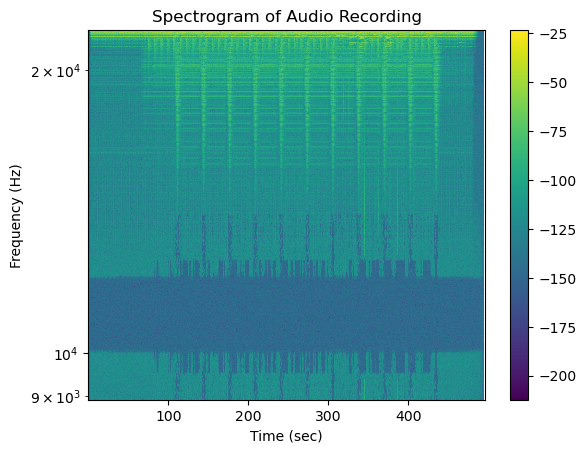

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Spectrogram of Audio Recording'}, xlabel='Time (sec)', ylabel='Frequency (Hz)'>)

In [11]:
%matplotlib inline
plot_recording(load_and_parse("The-Lights-Galaxia--While-She-Sleeps.mp3"))

In [15]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute
@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterating over each element in the the 2-D data 
    # in column-major ordering
    #
    # We want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c) to see
        # if (r, c) is associated with the largest value in that
        # neighborhood.
        #
        # dr: offset from r to visit neighbor
        # dc: offset from c to visit neighbor
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary.. skip!
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary.. skip!
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a local peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    # We always want our neighborhood to have an odd number
    # of nbrhd_row_offsets and nbrhd_col_offsets so that it has a distinct center element
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    
    # Find the indices of the 2D neighborhood where the 
    # values were `True`
    #
    # E.g. (row[i], col[i]) stores the row-col index for
    # the ith True value in the neighborhood (going in row-major order)
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    

    # Shift the neighbor indices so that the center element resides 
    # at coordinate (0, 0) and that the center's neighbors are represented
    # by "offsets" from this center element.
    #
    # E.g., the neighbor above the center will has the offset (-1, 0), and 
    # the neighbor to the right of the center will have the offset (0, 1).
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

In [16]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data and return a 2D array
    that is 1 wherever there is a peak and 0 where there is not.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    # Generate a rank-2, connectivity-2 neighborhood array
    # We will not use `iterate_structure` in this example
    neighborhood_array = generate_binary_structure(2, 2)  # <COGSTUB>

    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = local_peak_locations(data, neighborhood_array, cutoff)  # <COGSTUB>

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    peak_locations = np.array(peak_locations)

    # create a boolean mask of zeros with the same shape as `data`
    mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

In [17]:
def plot_compare(
    data: np.ndarray,
    peak_rendering_func: Callable[[np.ndarray], np.ndarray],
    cutoff: float = -np.inf,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the original data side-by-side with the binary indicator
    for the local peaks.

    Parameters
    ----------
    data : numpy.ndarray, shape=(N, H, W)
        N 2D arrays of shape (H, W)

    peak_finding_function : Callable[[ndarray], ndarray]
        A function that will locate the 2D peaks in `data` and
        create an image with the 2D peaks 

    cutoff : float, optional (default=-np.inf)
         A threshold value that distinguishes background from foreground
         
    Returns
    -------
    Tuple[matplotlib.Figure, matplotlib.Axes]
        The figure and axes objects of the plot
    """
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_rendering_func(dat, cutoff=cutoff))
    return fig, ax

KeyboardInterrupt: 

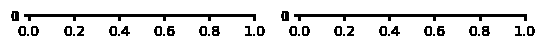

In [20]:
%matplotlib inline
plot_compare(load_and_parse("The-Lights-Galaxia--While-She-Sleeps.mp3"), local_peaks_mask);

fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Audio Recording")
ax.set_ylim(0, 6000);